In [1]:
#import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show

from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report, accuracy_score, classification_report
#rom sklearn.metrics import RocCurveDisplay

In [2]:
# Load the subset from the file
data = np.load('Tomato_balanced.npz')
X_train_balanced = data['X_train_balanced']
y_train_balanced = data['y_train_balanced']

In [3]:
# Load the subset from the file
data = np.load('Tomato_test.npz')
X_test = data['X_test']
y_test = data['y_test']

In [4]:
# Load the subset from the file
data = np.load('Tomato_val.npz')
X_val = data['X_val']
y_val = data['y_val']

In [5]:
# Print the shape of the features to check
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_val shape: {X_val.shape}")

X_train_balanced shape: (4252, 224, 224, 3)
X_test shape: (461, 224, 224, 3)
X_val shape: (902, 224, 224, 3)


In [6]:
#Identify class distribution
unique_classes, class_counts = np.unique(y_train_balanced, return_counts=True)

dict(zip(unique_classes, class_counts))

{0: 450, 1: 450, 2: 632, 3: 716, 4: 654, 5: 450, 6: 450, 7: 450}

In [7]:
img_shape = X_train_balanced.shape[1:]
img_shape

(224, 224, 3)

In [8]:
class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']
len(class_labels)

8

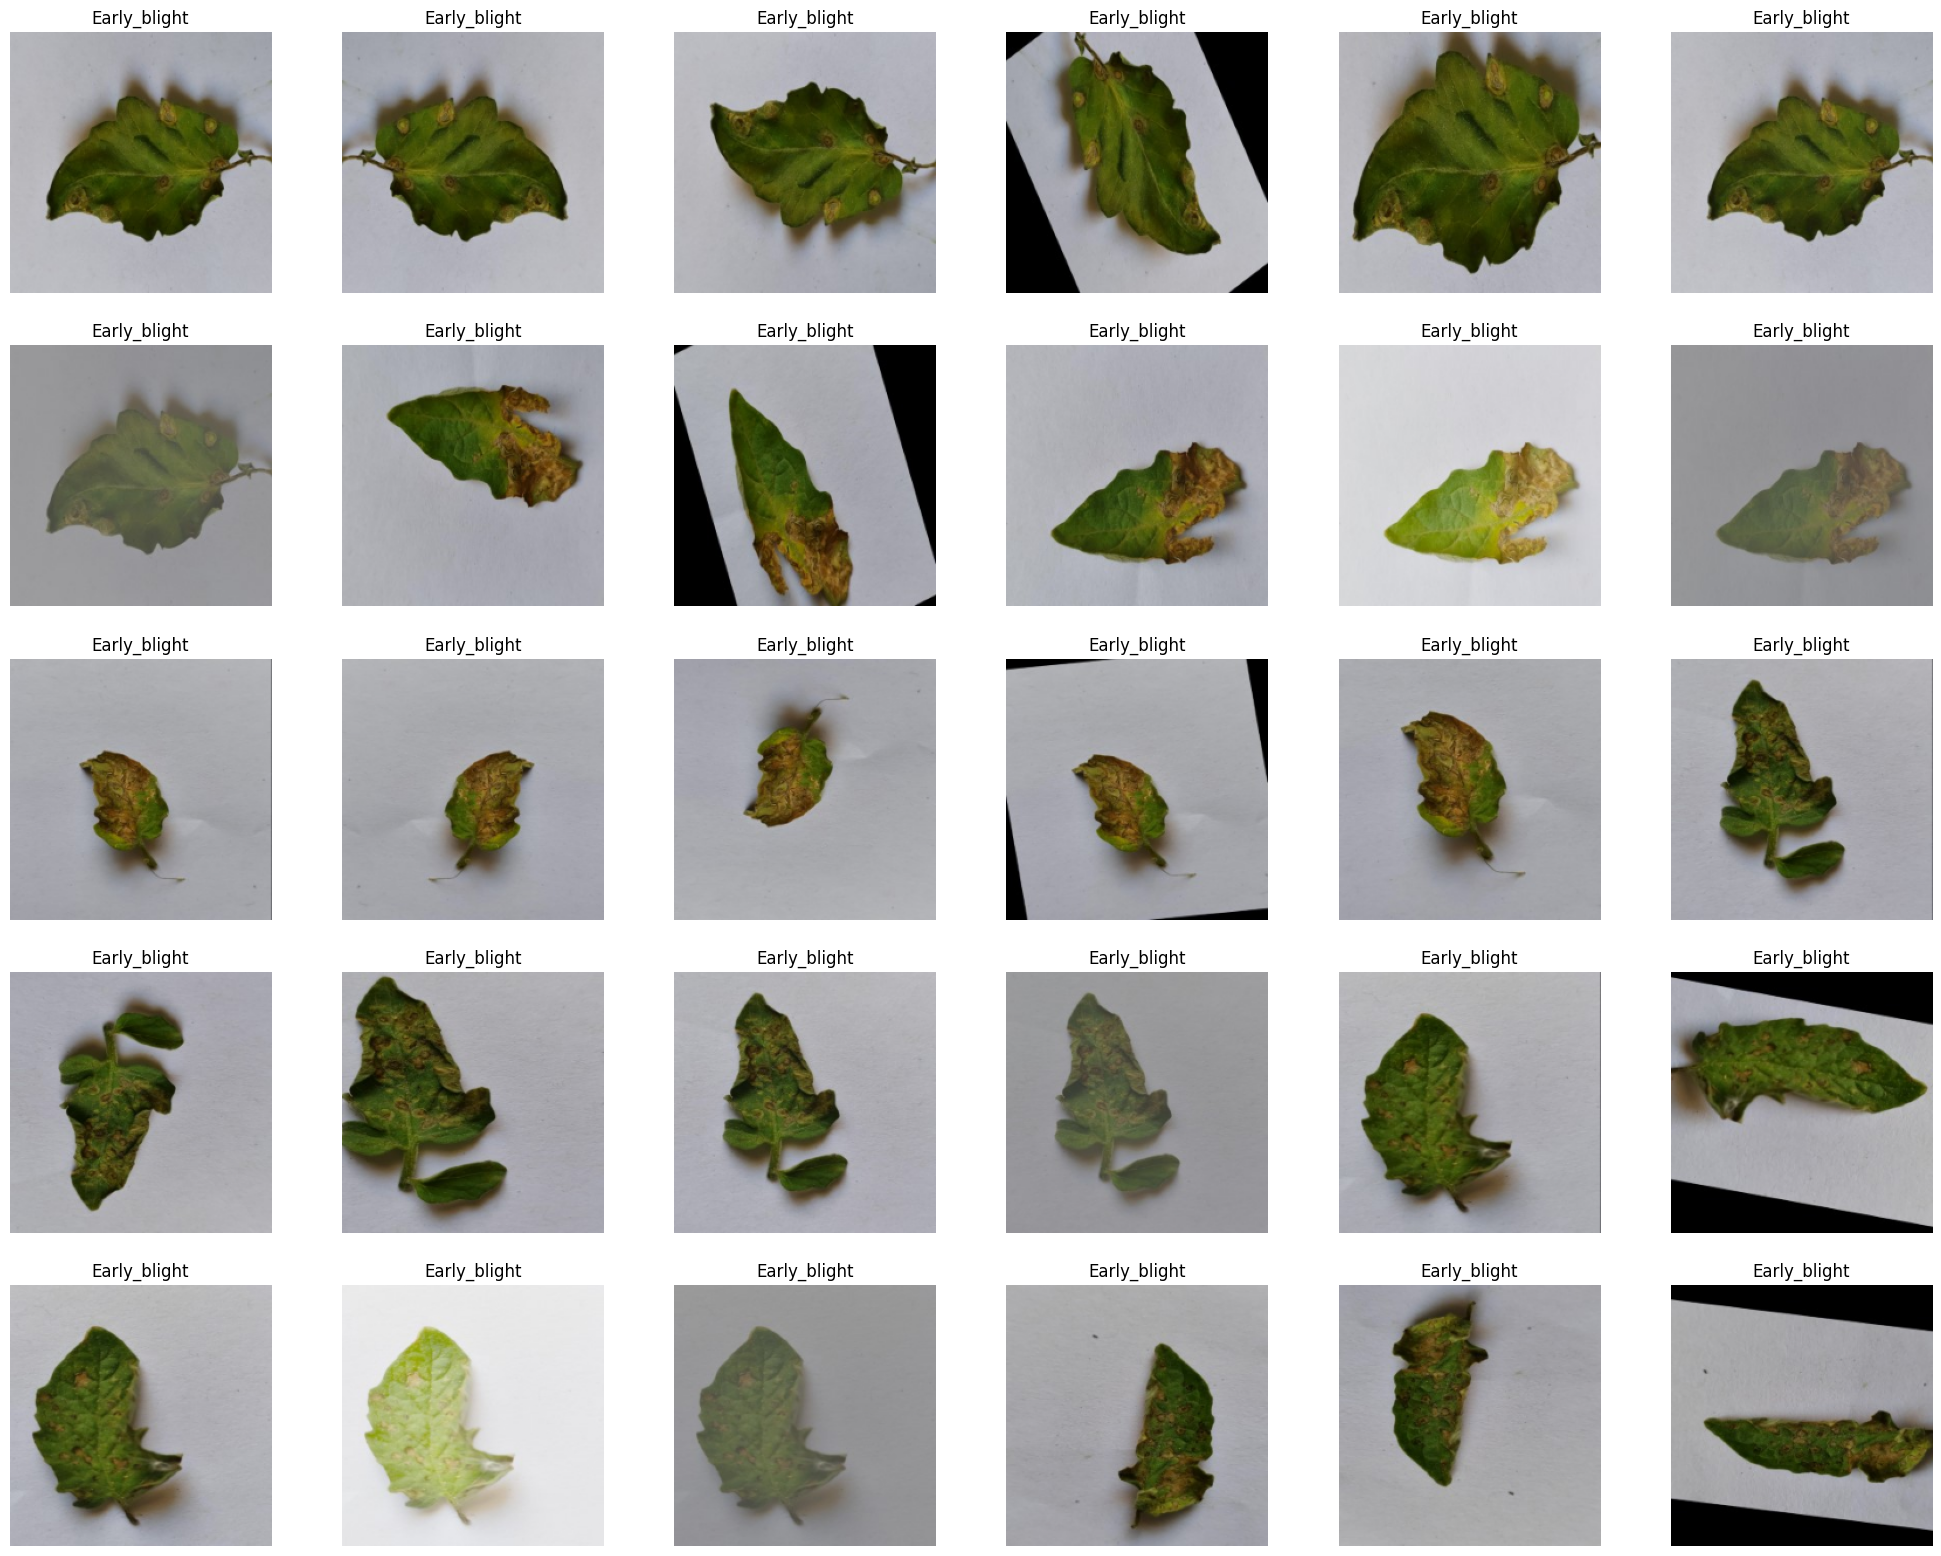

In [9]:
plt.figure(figsize=(25,40))
for i in range(30):
    plt.subplot(10,6,i+1)
    plt.imshow(X_train_balanced[i])
    plt.title(class_labels[y_train_balanced[i]])
    plt.axis("off")

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [11]:
base_model = tf.keras.applications.MobileNet(input_shape=img_shape,
                                               include_top=False, 
                                               weights='imagenet')

In [12]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [13]:
base_model.trainable = False

In [14]:
n_classes = 8
mobile = tf.keras.Sequential([
  base_model,
  #data_augmentation,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [15]:
mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 8200      
Total params: 3,237,064
Trainable params: 8,200
Non-trainable params: 3,228,864
_________________________________________________________________


In [16]:
mobile.compile(optimizer='adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(
                          from_logits=False,
                          name='sparse_categorical_crossentropy'),
             metrics = ['accuracy'])

In [17]:
import time
start = time.time()

history = mobile.fit(X_train_balanced, y_train_balanced, validation_data=(X_val, y_val), batch_size=16, epochs=50)

end = time.time()
total_time = end - start

Epoch 1/50
266/266 [==============================] - 11s 22ms/step - loss: 1.0328 - accuracy: 0.6428 - val_loss: 1.0222 - val_accuracy: 0.6319
Epoch 2/50
266/266 [==============================] - 5s 18ms/step - loss: 0.6274 - accuracy: 0.7900 - val_loss: 0.8315 - val_accuracy: 0.7173
Epoch 3/50
266/266 [==============================] - 5s 18ms/step - loss: 0.5052 - accuracy: 0.8316 - val_loss: 0.7518 - val_accuracy: 0.7483
Epoch 4/50
266/266 [==============================] - 5s 18ms/step - loss: 0.4319 - accuracy: 0.8584 - val_loss: 0.6988 - val_accuracy: 0.7461
Epoch 5/50
266/266 [==============================] - 5s 18ms/step - loss: 0.3739 - accuracy: 0.8819 - val_loss: 0.6769 - val_accuracy: 0.7605
Epoch 6/50
266/266 [==============================] - 5s 19ms/step - loss: 0.3346 - accuracy: 0.9005 - val_loss: 0.6387 - val_accuracy: 0.7916
Epoch 7/50
266/266 [==============================] - 5s 18ms/step - loss: 0.2912 - accuracy: 0.9127 - val_loss: 0.6506 - val_accuracy: 0.770

In [18]:
print(f"Total time taken for fitting: {total_time:.2f} sec")

Total time taken for fitting: 275.49 sec


In [19]:
mobile.evaluate(X_test, y_test)

15/15 [==============================] - 1s 51ms/step - loss: 0.7062 - accuracy: 0.8221


[0.7062362432479858, 0.8221257925033569]

Text(0.5, 1.0, 'Training and Validation Accuracy')

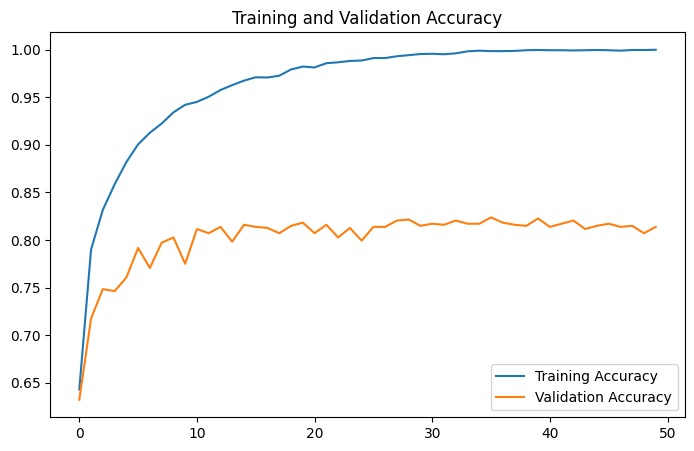

In [20]:
epochs =50

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

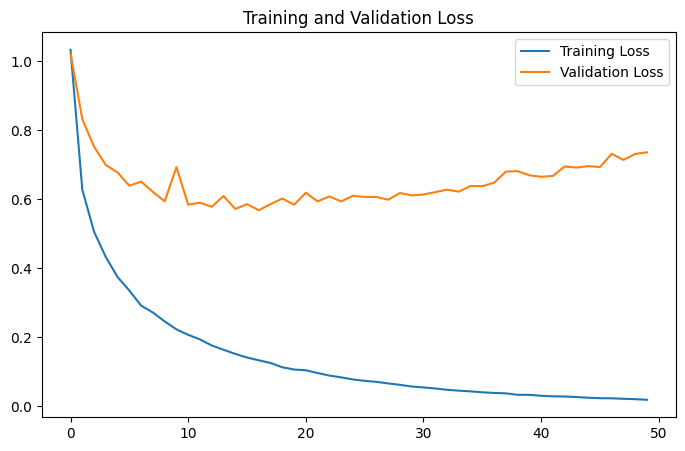

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# For TensorFlow/Keras models
mobile.save("mobileNet_freezed.h5")
print("Model saved to mobileNet_freezed.h5")

Model saved to mobileNet_freezed.h5


In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report

y_pred = mobile.predict(X_test) #### 3-dimentional

y_pred1 = np.array(list(map(lambda x: np.argmax(x), y_pred))) #pred_prob = np.argmax(y_pred, axis=1) ## 1-dimentional
    
report = classification_report(y_test, y_pred1)
    
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.79      0.50      0.61        22
           2       0.81      0.89      0.85        92
           3       0.85      0.89      0.87       104
           4       0.93      0.87      0.90        95
           5       0.75      0.97      0.85        37
           6       1.00      0.62      0.77         8
           7       0.67      0.49      0.57        53

    accuracy                           0.82       461
   macro avg       0.82      0.76      0.78       461
weighted avg       0.82      0.82      0.82       461



In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, RocCurveDisplay, recall_score, f1_score
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_test, y_pred1)
precision = precision_score(y_test, y_pred1, average='weighted')
recall = recall_score(y_test, y_pred1, average='weighted')
f1 = f1_score(y_test, y_pred1, average='weighted')
precision_per_class = precision_score(y_test, y_pred1, average=None)
f1_per_class = f1_score(y_test, y_pred1, average=None)

# Print metrics as percentages rounded to 2 decimal places
print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Print precision and F1 score per class, rounded to 2 decimal places as percentages
print(f"Precision per Class: {[round(p * 100, 2) for p in precision_per_class]}%")
print(f"F1 Score per Class: {[round(f * 100, 2) for f in f1_per_class]}%")

SVM Test Accuracy: 82.21%
Precision: 82.14%
Recall: 82.21%
F1 Score: 81.59%
Precision per Class: [78.18, 78.57, 81.19, 84.55, 93.26, 75.0, 100.0, 66.67]%
F1 Score per Class: [81.9, 61.11, 84.97, 86.92, 90.22, 84.71, 76.92, 56.52]%


[[43  0  2  0  3  1  0  1]
 [ 0 11  0  8  0  0  0  3]
 [ 0  0 82  2  0  3  0  5]
 [ 4  2  0 93  1  1  0  3]
 [ 3  1  1  2 83  4  0  1]
 [ 0  0  1  0  0 36  0  0]
 [ 1  0  0  0  1  1  5  0]
 [ 4  0 15  5  1  2  0 26]]


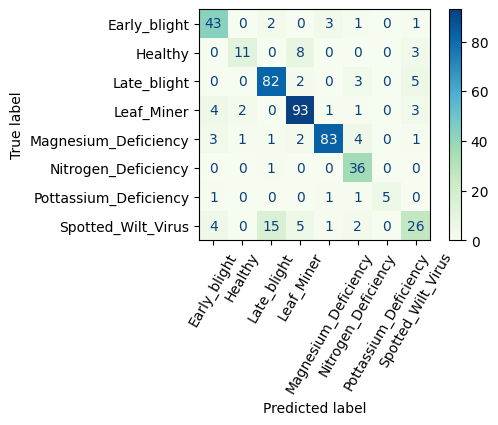

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred1)
print(cm)


display_cm = ConfusionMatrixDisplay(cm, display_labels=class_labels)
fig,ax = plt.subplots(figsize=(5,3))
display_cm.plot(cmap='GnBu', ax=ax, xticks_rotation=60)

In [28]:
from sklearn.metrics import roc_curve, auc
import sklearn

sklearn.metrics.roc_auc_score(y_test, y_pred, multi_class='ovr')

0.9729604792535409

In [29]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred1)

0.7856944436570612

In [30]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred)

0.7062363001277573

In [31]:
from tensorflow.keras.utils import to_categorical
y_test_cat = tf.keras.utils.to_categorical(y_test)
y_test_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

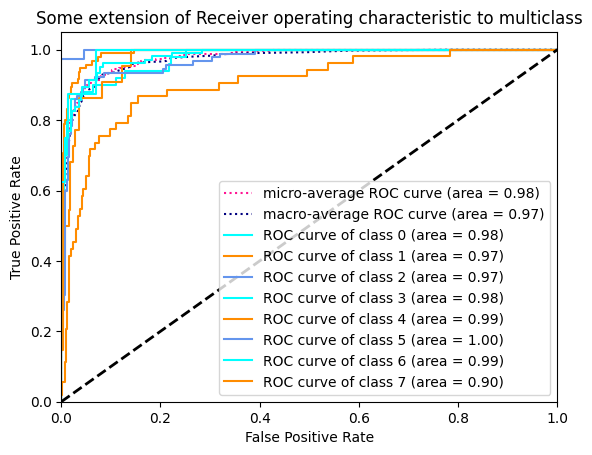

In [32]:
n_classes=8
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
from itertools import cycle
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



##### Plot all ROC curves ######


plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle="dotted",
    linewidth=1.5,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="dotted",
    linewidth=1.5,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1.5,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [33]:
from tensorflow.keras.models import load_model

# Load the  model
loaded_mobileNet = load_model("mobileNet_freezed.h5")
print("Model loaded from mobileNet_freezed.h5")

Model loaded from mobileNet_freezed.h5


In [34]:
loaded_mobileNet.evaluate(X_test, y_test)

15/15 [==============================] - 1s 33ms/step - loss: 0.7062 - accuracy: 0.8221


[0.7062362432479858, 0.8221257925033569]

In [36]:

# Select a single image and its corresponding actual label
index = 0  # Index of the test image in X_test
test_image = X_test[index]
actual_label_index = y_test[index]  # Assuming y_test contains the actual labels as indices

# Add a batch dimension (required by the CNN model)
test_image = np.expand_dims(test_image, axis=0)  # Shape becomes (1, 224, 224, 3)

# Predict the class probabilities for the image
predictions = mobile.predict(test_image)


In [37]:
# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']
len(class_labels)


8

In [38]:
# Get the actual and predicted class labels
actual_label = class_labels[actual_label_index]
predicted_label = class_labels[predicted_class_index]

# Print both actual and predicted classes
print(f"Actual Class: {actual_label} (Index: {actual_label_index})")
print(f"Predicted Class: {predicted_label} (Index: {predicted_class_index})")

Actual Class: Early_blight (Index: 0)
Predicted Class: Early_blight (Index: 0)


In [44]:
import numpy as np
import random

# Select 20 random indices from the test set
random_indices = random.sample(range(len(X_test)), 20)

class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']

# Loop through the randomly selected indices
for index in random_indices:
    # Select the test image and its corresponding actual label
    test_image = X_test[index]
    actual_label_index = y_test[index]  # Assuming y_test contains the actual labels as indices

    # Add a batch dimension (required by the CNN model)
    test_image = np.expand_dims(test_image, axis=0)  # Shape becomes (1, 224, 224, 3)

    # Predict the class probabilities for the image
    predictions = mobile.predict(test_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the actual and predicted class labels
    actual_label = class_labels[actual_label_index]
    predicted_label = class_labels[predicted_class_index]

    # Print both actual and predicted classes
    print(f"Image Index: {index}")
    print(f"Actual Class: {actual_label} (Index: {actual_label_index})")
    print(f"Predicted Class: {predicted_label} (Index: {predicted_class_index})")
    print("-" * 50)  # Separator for readability


Image Index: 168
Actual Class: Leaf_Miner (Index: 3)
Predicted Class: Leaf_Miner (Index: 3)
--------------------------------------------------
Image Index: 218
Actual Class: Leaf_Miner (Index: 3)
Predicted Class: Leaf_Miner (Index: 3)
--------------------------------------------------
Image Index: 382
Actual Class: Nitrogen_Deficiency (Index: 5)
Predicted Class: Nitrogen_Deficiency (Index: 5)
--------------------------------------------------
Image Index: 70
Actual Class: Healthy (Index: 1)
Predicted Class: Healthy (Index: 1)
--------------------------------------------------
Image Index: 215
Actual Class: Leaf_Miner (Index: 3)
Predicted Class: Nitrogen_Deficiency (Index: 5)
--------------------------------------------------
Image Index: 304
Actual Class: Magnesium_Deficiency (Index: 4)
Predicted Class: Magnesium_Deficiency (Index: 4)
--------------------------------------------------
Image Index: 42
Actual Class: Early_blight (Index: 0)
Predicted Class: Early_blight (Index: 0)
-------

Image Index: 400


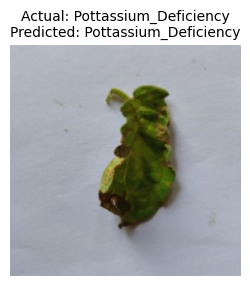

Image Index: 248


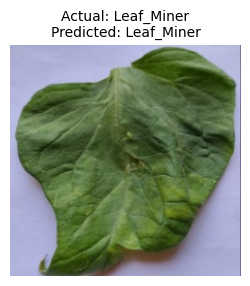

Image Index: 196


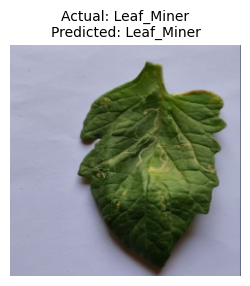

Image Index: 316


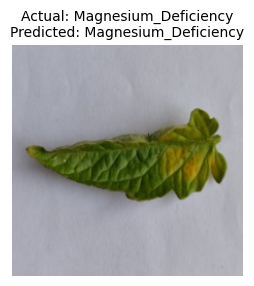

Image Index: 279


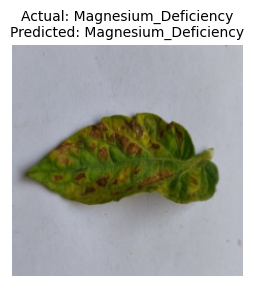

Image Index: 219


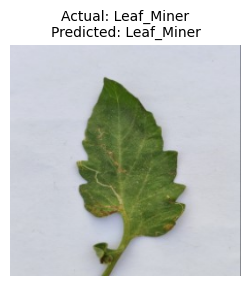

Image Index: 55


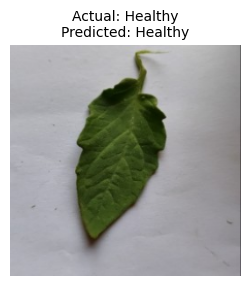

Image Index: 419


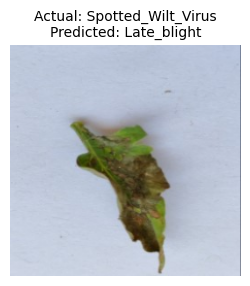

Image Index: 423


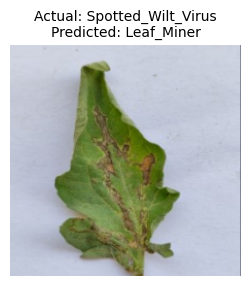

Image Index: 107


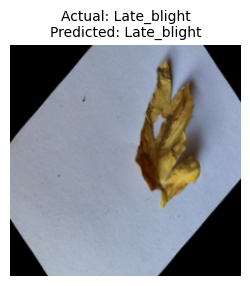

Image Index: 179


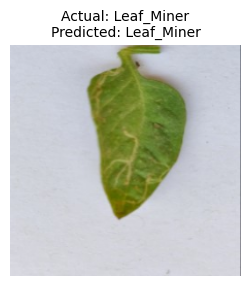

Image Index: 158


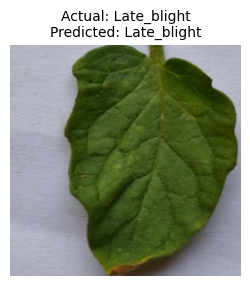

Image Index: 110


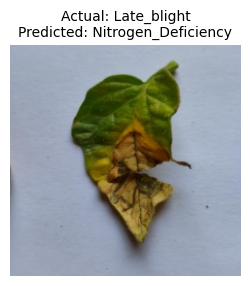

Image Index: 389


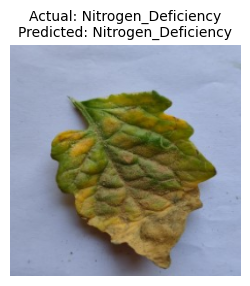

Image Index: 420


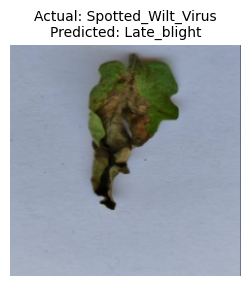

Image Index: 95


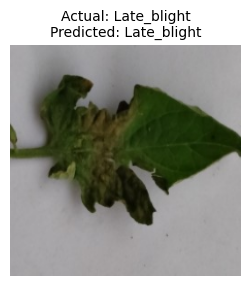

Image Index: 199


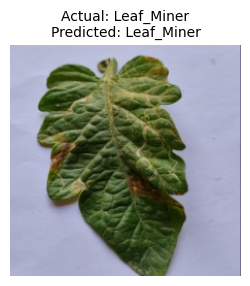

Image Index: 256


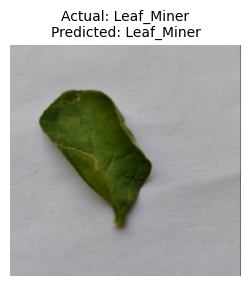

Image Index: 272


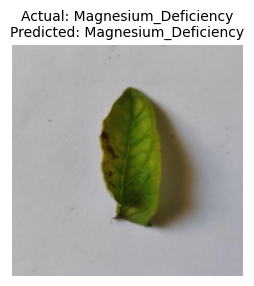

Image Index: 310


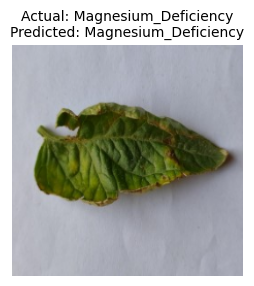

In [47]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 20 random indices from the test set
random_indices = random.sample(range(len(X_test)), 20)

class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']

# Loop through the randomly selected indices
for index in random_indices:
    # Select the test image and its corresponding actual label
    test_image = X_test[index]
    actual_label_index = y_test[index]  # Assuming y_test contains the actual labels as indices

    # Add a batch dimension (required by the CNN model)
    test_image_batch = np.expand_dims(test_image, axis=0)  # Shape becomes (1, 224, 224, 3)

    # Predict the class probabilities for the image
    predictions = mobile.predict(test_image_batch)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the actual and predicted class labels
    actual_label = class_labels[actual_label_index]
    predicted_label = class_labels[predicted_class_index]

    # Display the image with Matplotlib
    plt.figure(figsize=(3, 3))  # Set figure size

    # If the image is normalized, scale it back to the range [0, 255] for display
    if test_image.max() <= 1.0:
        display_image = test_image * 255  # Rescale to [0, 255]
    else:
        display_image = test_image  # If already in [0, 255], keep it as is

    # Display the image
    print(f"Image Index: {index}")
    plt.imshow(display_image.astype('uint8'))  # Convert to uint8 for correct display
    plt.axis('off')  # Turn off axis
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)  # Add title
    plt.show()
